# State Prison Infection Rates over Time
This notebook uses the Marshall Project's data to visualize covid infection rates in prisons across the US.
Scroll to the bottom of the notebook for the map.

Download the csv files with `retrieve_data.py` before running this notebook.

Geopandas handles geographic data. Folium is for creating the dynamic map.

In [1]:
import geopandas as gpd
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timezone
from branca.colormap import linear
import folium
from folium.plugins import TimeSliderChoropleth

### Import the map overlay data
Download and save the geographic `json` data for the United States' boundaries.

In [2]:
url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json"
resp = requests.get(url)

with open('us-states.json', 'wb') as f:
    f.write(resp.content)

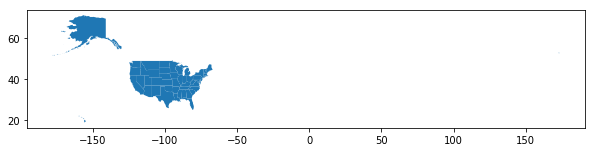

In [3]:
datapath = 'us-states.json'
gdf = gpd.read_file(datapath)
%matplotlib inline
ax = gdf.plot(figsize=(10,10))

Definitely the right country. I'd like to bring Alaska and Hawaii in though so that I can see everything up close.

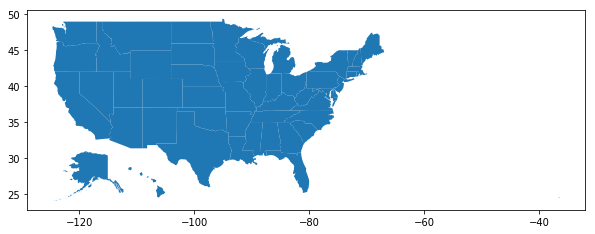

In [4]:
mask = gdf.id == "HI"
gdf[mask] = gdf[mask].set_geometry(gdf[mask].scale(1.3,1.3).translate(49,6))
mask = gdf.id == "AK"
gdf[mask] = gdf[mask].set_geometry(gdf[mask].scale(.25,.35).translate(-78,-34))
ax = gdf.plot(figsize=(10,10))

# Prep

### Import state prison covid counts

In [5]:
cases = pd.read_csv("covid_prison_cases.csv")

In [6]:
cases.head()

,name,abbreviation,staff_tests,staff_tests_with_multiples,total_staff_cases,staff_recovered,total_staff_deaths,prisoner_tests,prisoner_tests_with_multiples,total_prisoner_cases,prisoners_recovered,total_prisoner_deaths,as_of_date,notes
0,Alabama,AL,NaN,NaN,863.0,550.0,2.0,NaN,14447.0,1262.0,1026.0,54.0,01/12/2021,NaN
1,Alaska,AK,NaN,NaN,257.0,NaN,0.0,NaN,18507.0,2222.0,NaN,5.0,01/12/2021,They are vaccinating but not tracking numbers.
2,Arizona,AZ,NaN,NaN,2137.0,1693.0,NaN,NaN,43136.0,8042.0,6591.0,44.0,01/12/2021,NaN
3,Arkansas,AR,NaN,NaN,NaN,NaN,4.0,NaN,NaN,10832.0,10696.0,51.0,01/12/2021,NaN
4,California,CA,NaN,NaN,13957.0,11311.0,13.0,NaN,115858.0,44079.0,38028.0,162.0,01/12/2021,NaN


### Subset
To just the rows with collection date and case count info. Exclude rows for the federal count.
Do the same for the rates.

In [7]:
cases = cases[cases['as_of_date'].notnull()]
cases = cases[cases['total_prisoner_cases'].notnull()]
cases = cases[cases['name'] != "Federal"]

Note that we have data for each state (only the first five shown here).

In [8]:
cases[['name','total_prisoner_cases','as_of_date']].head()

,name,total_prisoner_cases,as_of_date
0,Alabama,1262.0,01/12/2021
1,Alaska,2222.0,01/12/2021
2,Arizona,8042.0,01/12/2021
3,Arkansas,10832.0,01/12/2021
4,California,44079.0,01/12/2021


And for each state, we have data for many different points in time.

In [9]:
cases[['name','total_prisoner_cases','as_of_date']][cases['name']=='Tennessee'].head()

,name,total_prisoner_cases,as_of_date
41,Tennessee,6392.0,01/12/2021
92,Tennessee,6353.0,01/05/2021
143,Tennessee,6211.0,12/29/2020
194,Tennessee,6194.0,12/22/2020
245,Tennessee,6137.0,12/15/2020


### Create Index
Create a `DatetimeIndex` instance of the collection dates. This is necessary for use within Folium.

In [10]:
# Sort the dates
collection_dates = cases['as_of_date'].unique()
sorted_dates = sorted(collection_dates, key=lambda x: datetime.strptime(x, '%m/%d/%Y'))

In [11]:
# Create the index
dt_index = pd.DatetimeIndex(sorted_dates).astype(int).astype("U10")

### Gather and Organize
Create a new dataframe from `cases`. It needs to have states in alphabetical order as the rownames, collection dates as the column names, and current prisoner cases as the values.

In [12]:
# Pull out a list of the states
states = cases["name"].unique()
states.sort() # alphabetized

In [13]:
# Create an empty dataframe with rows indexed by the alphabetical states
df = pd.DataFrame(index=states)

In [14]:
# Load that dataframe with the case values corresponding to each state and collection date.
for date in sorted_dates:
    names_cases = cases[cases['as_of_date']==date][['name','total_prisoner_cases']]
    df = pd.merge(df, names_cases, how='left', left_on=df.index, right_on="name")
    df.index = df['name']
    df.drop("name", axis=1, inplace=True)
    df.rename(columns={'total_prisoner_cases':date}, inplace = True)

The empty (`NaN`) values in this dataframe result from states submitting their data on different days.

For instance, you can see below that Alabama is the only one of these five states with a case count for the date `03/31/2020`. This means Alabama submitted data on that day, but none of those other four states did. On the next day, however, we hear from the other four states. 

If a state didn't report a case count on a given day, we will use their last reported count.

In [15]:
df.head()

,03/24/2020,03/25/2020,03/26/2020,03/27/2020,03/31/2020,04/01/2020,04/02/2020,04/03/2020,04/06/2020,04/07/2020,...,12/31/2020,01/04/2021,01/05/2021,01/06/2021,01/07/2021,01/11/2021,01/12/2021,01/13/2021,01/14/2021,01/15/2021
name,,,,,,,,,,,,,,,,,,,,,
Alabama,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1262.0,NaN,NaN,NaN
Alaska,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,2153.0,NaN,NaN,NaN,2222.0,NaN,NaN,NaN
Arizona,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,7608.0,NaN,NaN,NaN,8042.0,NaN,NaN,NaN
Arkansas,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,10741.0,NaN,NaN,NaN,10832.0,NaN,NaN,NaN
California,NaN,NaN,1.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,41562.0,NaN,NaN,NaN,44079.0,NaN,NaN,NaN


### Calculate Infection Rate

Visualizing absolute case numbers would show California and Texas having particularly bad outcomes compared to other states, but this is largely due to their having higher prisoner populations. To be able to compare from one state to the next, we'll calculate a rate of infection based on prison population numbers and covid case counts.

Since populations were reported fewer (and at different) times than case numbers were, we'll estimate population at each covid case report date via interpolation.

In [16]:
import pandas as pd
# Read in the population data
raw_pop = pd.read_csv("prison_populations.csv")

In [17]:
raw_pop = raw_pop.set_index('name')
raw_pop.head()

,abbreviation,march_pop,april_pop,june_pop,july_pop,aug_pop,sept_pop,oct_pop,as_of_date_march,as_of_date_april,as_of_date_june,as_of_date_july,as_of_date_aug,as_of_date_sept,as_of_date_oct
name,,,,,,,,,,,,,,,
Alabama,AL,21114,20655,19752,19342,18901,18693,18693,03/31/2020,04/30/2020,06/30/2020,07/31/2020,08/31/2020,09/30/2020,09/30/2020
Alaska,AK,4776,4277,4216,4334,4414,4511,4586,03/15/2020,04/15/2020,06/16/2020,07/31/2020,08/31/2020,09/30/2020,10/31/2020
Arizona,AZ,42360,41777,40529,39626,39422,39169,38760,03/31/2020,04/30/2020,06/30/2020,07/31/2020,08/31/2020,09/30/2020,10/31/2020
Arkansas,AR,17501,17502,16473,15736,14382,13987,13795,03/15/2020,04/15/2020,06/16/2020,07/31/2020,08/31/2020,09/30/2020,10/30/2020
California,CA,117639,113632,109800,102715,97342,94852,94433,03/11/2020,04/15/2020,06/17/2020,07/29/2020,09/02/2020,09/30/2020,11/04/2020


In [18]:
# Extract the date info. States are columns, labels are indices.
dates = raw_pop.loc[:, "as_of_date_march":"as_of_date_oct"].T
dates = dates.astype('datetime64')
dates.head()

name,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Federal
as_of_date_march,2020-03-31,2020-03-15,2020-03-31,2020-03-15,2020-03-11,2020-03-31,2020-03-15,2020-03-15,2020-03-15,2020-04-01,...,2020-03-15,2020-03-31,2020-03-15,2020-03-15,2020-03-13,2020-03-31,2020-03-15,2020-03-13,2020-03-15,2020-03-12
as_of_date_april,2020-04-30,2020-04-15,2020-04-30,2020-04-15,2020-04-15,2020-04-30,2020-04-15,2020-04-15,2020-04-15,2020-05-01,...,2020-04-15,2020-04-30,2020-04-15,2020-04-15,2020-04-14,2020-04-30,2020-04-15,2020-04-17,2020-04-15,2020-04-16
as_of_date_june,2020-06-30,2020-06-16,2020-06-30,2020-06-16,2020-06-17,2020-06-30,2020-06-16,2020-06-25,2020-06-16,2020-07-01,...,2020-06-16,2020-06-26,2020-06-16,2020-06-16,2020-06-16,2020-06-30,2020-06-15,2020-06-12,2020-06-16,2020-06-18
as_of_date_july,2020-07-31,2020-07-31,2020-07-31,2020-07-31,2020-07-29,2020-07-31,2020-08-01,2020-07-31,2020-07-31,2020-08-01,...,2020-07-31,2020-07-31,2020-07-31,2020-07-31,2020-07-31,2020-07-31,2020-07-31,2020-07-31,2020-07-31,2020-07-31
as_of_date_aug,2020-08-31,2020-08-31,2020-08-31,2020-08-31,2020-09-02,2020-08-31,2020-09-01,2020-08-31,2020-09-01,2020-09-01,...,2020-08-31,2020-08-31,2020-08-31,2020-08-31,2020-08-31,2020-08-31,2020-08-31,2020-09-04,2020-08-31,2020-08-27


In [19]:
# Extract the population data. Columns are states, labels are indices.
pops = raw_pop.loc[:, "march_pop":"oct_pop"].T
pops.head()

name,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Federal
march_pop,21114,4776,42360,17501,117639,17585,12290,5042,93794,55019,...,21616,140124,6900,1656,29161,17263,5952,23591,2156,172088
april_pop,20655,4277,41777,17502,113632,16382,11454,4624,91828,53642,...,21150,135833,6441,1406,28559,16906,5556,22507,2098,167720
june_pop,19752,4216,40529,16473,109800,15807,10206,4233,88305,51213,...,20079,127200,5993,1395,28595,15837,4898,21576,2001,154707
july_pop,19342,4334,39626,15736,102715,15531,9645,4195,86100,50446,...,19249,124181,5915,1390,26749,15626,4398,21252,1986,150025
aug_pop,18901,4414,39422,14382,97342,15022,9545,4216,84601,49848,...,19279,121128,5824,1417,26190,15494,4331,21136,1959,147457


In [20]:
# Create an empty DF to fill in. Each column is a state. Indexed by DateTimeIndex.
full_date_range = pd.to_datetime(pd.date_range(dates.min().min(), dates.max().max()))
full_dates = pd.DataFrame(columns=pops.columns, index=full_date_range, dtype=int)
full_dates.head()

name,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Federal
2019-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Sparsely fill in our data where we have it.
for state in full_dates.columns:
    x = dates[state]
    y = pops[state]
    full_dates[state][x] = list(y) # list(y) so that items aren't joined by index
full_dates.tail()

name,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Federal
2020-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-04,NaN,NaN,NaN,NaN,94433.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145718.0


In [22]:
# Interpolate what our NaNs should be. limit_direction='both' ensures we extrapolate the data
# past the last sample (eg all the way from min date to max date)
full_dates = full_dates.interpolate(method='time', limit_direction='both')
full_dates

name,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Federal
2019-09-30,21114.0,4776.0,42360.0,17501.0,117639.000000,17585.0,12290.0,5042.0,93794.0,48433.0,...,21616.0,140124.0,6900.0,1656.0,29161.0,17263.0,5952.0,23591.0,2156.0,172088.000000
2019-10-01,21114.0,4776.0,42360.0,17501.0,117639.000000,17585.0,12290.0,5042.0,93794.0,48433.0,...,21616.0,140124.0,6900.0,1656.0,29161.0,17263.0,5952.0,23591.0,2156.0,172088.000000
2019-10-02,21114.0,4776.0,42360.0,17501.0,117639.000000,17585.0,12290.0,5042.0,93794.0,48433.0,...,21616.0,140124.0,6900.0,1656.0,29161.0,17263.0,5952.0,23591.0,2156.0,172088.000000
2019-10-03,21114.0,4776.0,42360.0,17501.0,117639.000000,17585.0,12290.0,5042.0,93794.0,48433.0,...,21616.0,140124.0,6900.0,1656.0,29161.0,17263.0,5952.0,23591.0,2156.0,172088.000000
2019-10-04,21114.0,4776.0,42360.0,17501.0,117639.000000,17585.0,12290.0,5042.0,93794.0,48433.0,...,21616.0,140124.0,6900.0,1656.0,29161.0,17263.0,5952.0,23591.0,2156.0,172088.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,18693.0,4586.0,38760.0,13795.0,94468.914286,14673.0,9348.0,4457.0,82163.0,49365.0,...,19566.0,122177.0,5824.0,1369.0,25156.0,15198.0,4172.0,20796.0,1996.0,145841.885714
2020-11-02,18693.0,4586.0,38760.0,13795.0,94456.942857,14673.0,9348.0,4457.0,82163.0,49365.0,...,19566.0,122177.0,5824.0,1369.0,25156.0,15198.0,4172.0,20796.0,1996.0,145810.914286
2020-11-03,18693.0,4586.0,38760.0,13795.0,94444.971429,14673.0,9348.0,4457.0,82163.0,49365.0,...,19566.0,122177.0,5824.0,1369.0,25156.0,15198.0,4172.0,20796.0,1996.0,145779.942857
2020-11-04,18693.0,4586.0,38760.0,13795.0,94433.000000,14673.0,9348.0,4457.0,82163.0,49365.0,...,19566.0,122177.0,5824.0,1369.0,25156.0,15198.0,4172.0,20796.0,1996.0,145748.971429


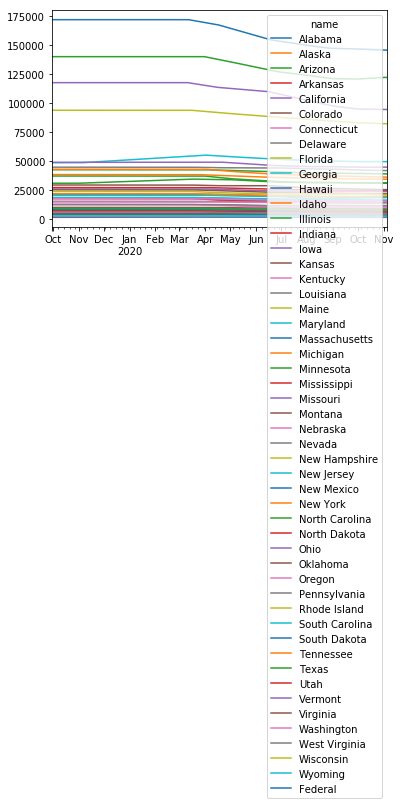

In [23]:
# We have data for every date and every state now
full_dates.plot()

In [35]:
pop = pd.read_csv("prison_populations.csv")

In [36]:
import matplotlib.pyplot as plt

In [37]:
# For converting dates to numerical values during interpolation
def date_to_num(date):
    d = datetime.strptime(date, '%m/%d/%Y')
    d = d.replace(tzinfo=timezone.utc)
    return d.timestamp()

In [38]:
def get_known_values(state):
    # Dates at which population data was reported for this state
    state_dates = pd.Series(list(pop.loc[pop['name']==state, "as_of_date_march":"as_of_date_oct"].values[0]))
    state_dates = state_dates.apply(date_to_num)
    state_dates = state_dates.values.tolist()
    
    # State prison population at each date
    pop_vals = pop.loc[pop['name']==state, "march_pop":"oct_pop"].values.tolist()[0]

    return [state_dates, pop_vals]

In [39]:
def estimate_pop(target_date, state):
    [x, y] = get_known_values(state)
    xinterp = date_to_num(target_date)
    return np.interp(xinterp,x,y)

In [40]:
# Delete data later than each state's last population report. Though they might be using october as the last date.
for state in df.index:
    last_report = max(get_known_values(state)[0])
    df.loc[state][np.array([date_to_num(day) for day in df.loc[state].index.values]) > last_report] = np.nan

In [41]:
# Takes about 20 seconds
for state in df.index:
    state_cases = df.loc[state]
    dates = state_cases.index.values
    estimated_pop = [estimate_pop(day,state) for day in dates]
    df.loc[state] = state_cases/estimated_pop * 100

In [42]:
df.head()

,03/24/2020,03/25/2020,03/26/2020,03/27/2020,03/31/2020,04/01/2020,04/02/2020,04/03/2020,04/06/2020,04/07/2020,...,12/31/2020,01/04/2021,01/05/2021,01/06/2021,01/07/2021,01/11/2021,01/12/2021,01/13/2021,01/14/2021,01/15/2021
name,,,,,,,,,,,,,,,,,,,,,
Alabama,NaN,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alaska,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arizona,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arkansas,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
California,NaN,NaN,0.000863,NaN,NaN,0.006942,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


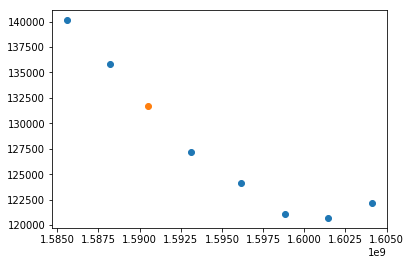

In [43]:
# Example: the orange dot is the estimated population on that day.

# Known data
[x,y] = get_known_values("Texas")

# Make estimate
day = "05/27/2020"
x_est = date_to_num(day)
y_est = estimate_pop(day, "Texas")

# Plot
plt.scatter(x,y)
plt.scatter(x_est, y_est)

In [44]:
# Change state name index to a numerical index (Alabama = 0, Wyoming = 49).
df_statenames = df.copy() # Save for later
df.index = np.arange(0,50)

### Create overlay
The Folium plugin for the choropleth map with a time slider takes two arguments:
1. A `geopandas` dataframe (converted to json)
2. The dictionary describing how to style the map overlay

We've already made the first thing. Now, we'll construct the second.

In [50]:
styledata = {}

for state in gdf.index:
    style_df = pd.DataFrame(
        {
            "color": np.array(df[df.index==state])[0], # rates over time for that state
            "opacity": np.ones(len(df.columns))#*0.75
        },
        index=dt_index,
    )
    style_df["color"].fillna(method="pad", inplace=True)
    style_df["color"].fillna(0, inplace=True)
    assert all(pd.notnull(style_df["color"]))
    styledata[state] = style_df

Now the map and the data are linked through the index running from `0` to `49`.

In [51]:
# Arkansas' geographical info
gdf.loc[3]

id                                                         AR
name                                                 Arkansas
geometry    POLYGON ((-94.473842 36.501861, -90.152536 36....
Name: 3, dtype: object

In [52]:
# Arkansas' infection data
styledata.get(3).tail()

,color,opacity
1610323200,54.501889,1.0
1610409600,54.501889,1.0
1610496000,54.501889,1.0
1610582400,54.501889,1.0
1610668800,54.501889,1.0


The value of the color at each timestamp represents the percent of prisoners in that state who have covid.
The opacity is fixed at 1.

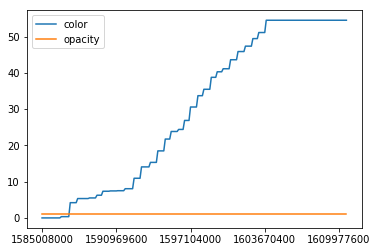

In [53]:
ax = styledata.get(3).plot()

We'll need to include the worst rate data in the geodataframe (for the tooltip which we'll add later):

In [54]:
worst_rate = []
for state in range(0,50):
    worst = max(styledata.get(state)['color'])
    worst = str(round(worst,1)) + "%"
    worst_rate.append(worst)

gdf['worst_rate'] = worst_rate
gdf.head()

,id,name,geometry,worst_rate
0,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",2.2%
1,AK,Alaska,"MULTIPOLYGON (((-112.70742 25.25471, -112.6992...",4.1%
2,AZ,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",6.8%
3,AR,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",54.5%
4,CA,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",17.0%


Now, we represent each color value as a hex color.

In [55]:
max_color = 0

for _, data in styledata.items():
    max_color = max(data["color"].max(), max_color)
    min_color = 0 # A universal minimum allows us to compare one state's color to another.

Define and apply color maps: 

In [56]:
cmap = linear.YlOrRd_09.scale(min_color, max_color)
for _, data in styledata.items():
    data["color"] = data["color"].apply(cmap)

In [57]:
styledata.get(0).head()

,color,opacity
1585008000,#ffffccff,1.0
1585094400,#ffffccff,1.0
1585180800,#ffffccff,1.0
1585267200,#ffffccff,1.0
1585612800,#ffffccff,1.0


Next, we convert each dataframe into a dictionary for use within Folium.

In [58]:
styledict = {
    str(state): data.to_dict(orient="index") for state, data in styledata.items()
}

Finally, we build the basemap and the overlay.

In [59]:
# The Overlay we care about
g = TimeSliderChoropleth(
    data=gdf.to_json(),
    styledict=styledict,
)

In [60]:
# Use an empty basemap to only show the overlay
m = folium.Map(location=[35,-96],
                zoom_start=4,
                tiles=None,
                zoom_control=False
               )

In [61]:
g.add_to(m)

Adding a legend will require a bit of a hack.

If this were a static choropleth overlay, a legend would come along for free. Since it isn't, we'll have to create a second overlay as a `folium.Choropleth` instance to get a legend. Then we'll set this new overlay's opacity to zero, leaving only its legend visible.

In [62]:
df_dict = {"name" : list(df_statenames.index),
           "counts_range" : max_color}

In [63]:
legend_df = pd.DataFrame(df_dict)
legend_df.iloc[0,1] = min_color

In [64]:
leg = folium.Choropleth(
    geo_data=gdf,
    bins=9,
    name="choropleth",
    data=legend_df,
    columns =['name','counts_range'],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0,
    line_opacity=1,
    legend_name="% of State Prisoners with Covid-19",
    smooth_factor=0.95,
    highlight=True,
)

Add the mouseover tooltip displaying each state's worst rate on the record.

In [65]:
style_options = 'background-color: black; color: white; font-family: "Pressura", monospace; font-weight: 900; font-size: 12px; padding: 5px'

tt = folium.features.GeoJsonTooltip(fields=["name", "worst_rate"],
                                    aliases=["", "Worst Rate on Record:"],
                                    sticky=True,
                                    style=style_options)
tt.add_to(leg.geojson)

In [66]:
leg.add_to(m)
m

Make sure to view the notebook through nbviewer so that the map renders properly. 
Alternatively, view the map by itself in GitHub Pages with the document below as the source.

In [67]:
m.save("index.html")